In [1]:
import tweepy as tw
import pandas as pd
import geopandas as gpd
from mordecai import Geoparser
import csv
import plotly_express as px

Using TensorFlow backend.


In [2]:
geo = Geoparser()
geo.geoparse("Eiffel Tower is located in Paris")

[{'word': 'Eiffel Tower',
  'spans': [{'start': 0, 'end': 12}],
  'country_predicted': 'FRA',
  'country_conf': 0.611725,
  'geo': {'admin1': 'Île-de-France',
   'lat': '48.85832',
   'lon': '2.29452',
   'country_code3': 'FRA',
   'geonameid': '6254976',
   'place_name': 'Tour Eiffel',
   'feature_class': 'S',
   'feature_code': 'MNMT'}},
 {'word': 'Paris',
  'spans': [{'start': 27, 'end': 32}],
  'country_predicted': 'FRA',
  'country_conf': 0.9881995,
  'geo': {'admin1': 'Île-de-France',
   'lat': '48.85339',
   'lon': '2.34864',
   'country_code3': 'FRA',
   'geonameid': '2988506',
   'place_name': 'Paris',
   'feature_class': 'A',
   'feature_code': 'ADM3'}}]

In [3]:
consumer_key= ''
consumer_secret= ''
access_token= ''
access_token_secret= ''

In [4]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [5]:
csvFile = open('tweets.csv', 'a')
csvWriter = csv.writer(csvFile)


In [9]:
def hashtag_to_csv(csv, hashtag, start_date, end_date):
    for tweet in tw.Cursor(api.search,q=hashtag,count=100,lang="en",since=start_date, until=end_date).items():
        csvWriter.writerow([tweet.created_at, tweet.text.encode('utf-8')])
    
    
    
hashtag = "#blacklivesmatter" + " -filter:retweets"
start_date = '2020-06-08'
end_date = '2020-06-09'

#hashtag_to_csv(csv=csvFile, hashtag=hashtag, start_date=start_date, end_date=end_date)

 

In [6]:
df = pd.read_csv("tweets.csv", header=None, names=["date", "tweet"])
df.head()

,date,tweet
0,2020-06-08 23:59:59,b'It was a powerful memorial to be at. I was i...
1,2020-06-08 23:59:59,b'Chants of \xe2\x80\x9cBlack Lives Matter\xe2...
2,2020-06-08 23:59:58,b'@louiseebrooks7 If #blacklivesmatter is anyt...
3,2020-06-08 23:59:57,"b'This is so chilling, raw, and powerful. Watc..."
4,2020-06-08 23:59:57,b'How do we #EndRacism? #StopTalkingAboutIt!\n...


In [7]:
df.shape


(29783, 2)

In [8]:
df["geoparse"] = [geo.geoparse(x) for x in df["tweet"]]


In [21]:
#df.to_csv("tweets_geoparsed.csv")

In [9]:
df.head()


,date,tweet,geoparse
0,2020-06-08 23:59:59,b'It was a powerful memorial to be at. I was i...,[]
1,2020-06-08 23:59:59,b'Chants of \xe2\x80\x9cBlack Lives Matter\xe2...,"[{'word': 'Downing Street', 'spans': [{'start'..."
2,2020-06-08 23:59:58,b'@louiseebrooks7 If #blacklivesmatter is anyt...,[]
3,2020-06-08 23:59:57,"b'This is so chilling, raw, and powerful. Watc...",[]
4,2020-06-08 23:59:57,b'How do we #EndRacism? #StopTalkingAboutIt!\n...,[]


In [10]:
#df = pd.read_csv("tweets_geoparsed.csv", index_col=0)
#df.head()

In [11]:
def flat_df(df):
    df_geo = df[df["geoparse"].str.len() != 0]
    df_geo = df_geo.explode('geoparse')
    df_geo = pd.concat([df_geo.drop(['geoparse'], axis=1), df_geo['geoparse'].apply(pd.Series)], axis=1)
    df_geo = pd.concat([df_geo.drop(['geo'], axis=1), df_geo['geo'].apply(pd.Series)], axis=1)
    df_geo = df_geo[df_geo['lat'].notnull()]
    df_geo.lat = df_geo.lat.astype(float)
    df_geo.lon =df_geo.lon.astype(float)
    return df_geo
    
df_clean = flat_df(df)   

In [12]:
df_clean.head()

,date,tweet,word,spans,country_predicted,country_conf,0,admin1,country_code3,feature_class,feature_code,geonameid,lat,lon,place_name
1,2020-06-08 23:59:59,b'Chants of \xe2\x80\x9cBlack Lives Matter\xe2...,Downing Street,"[{'start': 91, 'end': 105}]",USA,0.988199,NaN,Illinois,USA,P,PPL,6332021,42.13750,-87.87917,Downing Street Subdivision
25,2020-06-08 23:59:42,"b'@adamcarolla Ace, did you hear about former ...",@NFL,"[{'start': 46, 'end': 50}]",USA,0.937507,NaN,Nevada,USA,P,PPLA2,5503914,39.47353,-118.77737,Fallon
54,2020-06-08 23:59:19,b'And it looks like most of Piermont (populati...,Piermont,"[{'start': 28, 'end': 36}]",USA,0.937507,NaN,New York,USA,A,ADMD,7161818,41.04238,-73.91481,Village of Piermont
78,2020-06-08 23:59:04,b'\xf0\x9f\x93\xac I delivered this \xe2\x9c\x...,Anderson,"[{'start': 92, 'end': 100}]",USA,0.964745,NaN,South Carolina,USA,P,PPLA2,4569298,34.50344,-82.65013,Anderson
78,2020-06-08 23:59:04,b'\xf0\x9f\x93\xac I delivered this \xe2\x9c\x...,S.C.,"[{'start': 102, 'end': 106}]",CHE,0.833024,NaN,Neuchâtel,CHE,S,BUSTP,10387765,47.01332,6.84785,"Les Geneveys-s.C., Bellevue"


In [13]:
df_clean.shape

(2603, 15)

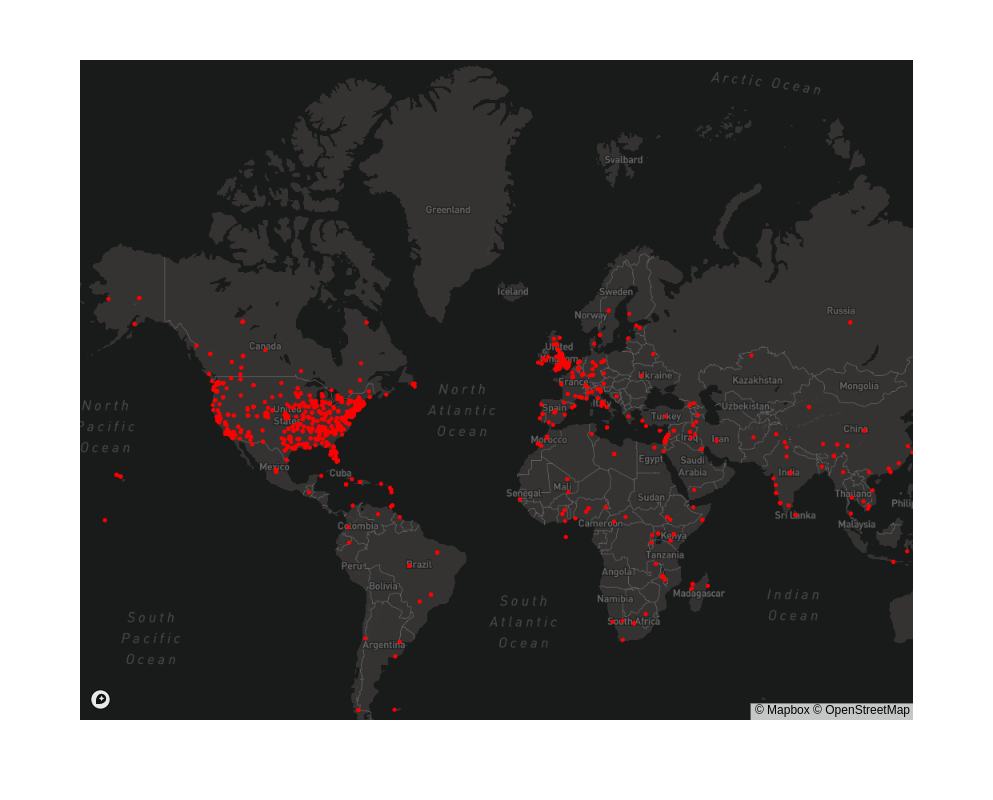

In [16]:
px.set_mapbox_access_token("")

fig = px.scatter_mapbox(df_clean, lat="lat", lon="lon", size_max=15, zoom=1, width=1000, height=800, mapbox_style="dark")
fig.data[0].marker = dict(size = 5, color="red")
fig